<center> <h1>5. Ensemble Model</h1> </center> 
<center> <h2>by Michelle Veriah</h2> </center> 
<br/>

## Write Up 

### Exploratory Work:  

When I first approached the assignment, I treated it as an object detection problem. I would first use a pre-trained object detection model to identify objects in an image, then count the distinct bounding boxes as a separate object each. However, I faced multiple issues with this approach. First, when running my model thru the pre-trained object detection models, the outputs of those models gave multiple bounding boxes on a single object. Thankfully, I was able to solve this problem via NMS (Non-Maximum Suppression) and WFB (Weighted Fusion Boxes). The second problem I faced was that the training datasets did not provide bounding boxes. Since I could not train the model with data needed, the best thing I could do was use the “count” outputs of the pre-trained object detection model as inputs to another model, then train said model so that the counts match. However, this did not seemed to be a good solution, since the inputs to the models were not from the original dataset, and could turn back poor results. 

### Modelling Approach: 

Thus, I took a step back and returned to what we’ve learned in class so far. I settled on using CNNs and other pre-trained image classification models for the assignment. The idea is that the models would extract features out of the images, then decode it to the correct classification and count. I created my own CNN model, and also used other pre-trained models. From the other pertained models, I found MobileNet to be the best for this assignment, but also included my own CNN model and ResNet model so that we could improve overall performance via ensemble model.

Another theory I tested out while working on this assignment is whether to train my models on categories (vehicle and signal) or on class/labels (car, bus, truck, train, motorcycle, bicycle, airplane, boat, traffic light, and stop light). My hypothesis is that there are similarity within the categories -- for example, bicycles and motorcycles are kind of similar, and so are cars and trucks. Thus, I tested my model on two different outputs, but in the end found that models predicting individual classes were better for overall prediction. 

### Individual Models: 

**As such, I arrived to my two models:** 
* Model A: CNN from Scratch 
* Model B: CNN with Transfer Learning from MobileNet 
* Model C: CNN with Transfer Learning from ResNet  

### Parameter Hypertuning: 

After creating the models, I implemented some steps to hypertune them. 

For Model A, I experimented with DropOut layers, BatchNormalization layers, and learning rates. For Model C, I also tried out different learning rates to improve accuracy. Interestingly, not much helped improve the Model B, so I left it as is. 


### Ensemble Model: 

For my ensemble model, I decided to use a blending method. First, I initialized the three models mentioned above on training dataset. Then, I use these initial models to make predictions on a dataset (let’s call it blending dataset), which is used as the training dataset for the ensemble model. We also have a holdout test dataset that will help us evaluate the overall ensemble model. For the purpose of comparing models, I will also use this holdout test dataset to evaluate the initial models. 

My ensemble model itself was a neural network model. I experimented with learning rates and epochs to improve the ensemble model. 

## Results: 

As expected, the ensemble model performed better than the individual models by themselves. 

<br/>

## Part 1. Set Up

In [2]:
!pip install tensorflow 

In [388]:
import pandas as pd
import numpy as np
import random

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout, Lambda, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping
from keras.applications.mobilenet import preprocess_input

from sklearn.linear_model import LinearRegression

In [4]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<br/>

## Part 2. Formulas

In [5]:
def load_and_preprocess_images(file_names, preprocess = True): 
    
    # Allocating an array for all images right away to avoid
    # storing images in a temporary Python list, which takes extra memory.
    images = np.empty((len(file_names), 224, 224, 3), dtype=np.float16)
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        image_path = f"carnet_dataset/train/images/{file_name}"
        image_pixels = np.array(Image.open(image_path), dtype=np.float32)
        if preprocess:
            image_pixels = preprocess_input(image_pixels) 
        images[i] = image_pixels.astype(np.float16)
        
    return np.array(images)

In [430]:
def score_load_and_preprocess_images(file_names, preprocess = True): 
    
    # Allocating an array for all images right away to avoid
    # storing images in a temporary Python list, which takes extra memory.
    images = np.empty((len(file_names), 224, 224, 3), dtype=np.float16)
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        image_path = f"carnet_dataset/score/images/{file_name}"
        image_pixels = np.array(Image.open(image_path), dtype=np.float32)
        if preprocess:
            image_pixels = preprocess_input(image_pixels) 
        images[i] = image_pixels.astype(np.float16)
        
    return np.array(images)

<br/>

## Part 3. Data Exploration & Pre-Processing

### Part 3A. Load Data 

In [6]:
# Download the dataset once
if not os.path.exists('carnet_dataset'):
    !aws s3 cp s3://danylo-ucla/carnet_dataset.zip ./
    !unzip -u -q carnet_dataset.zip
    
# Look at directory
!tree -L 2 carnet_dataset

carnet_dataset
├── score
│   ├── images
│   └── metadata.csv
└── train
    ├── images
    └── metadata.csv

4 directories, 2 files


In [7]:
# Load and check out training data 
train_metadata = pd.read_csv('carnet_dataset/train/metadata.csv')
print(train_metadata.shape)
train_metadata.head()

(23228, 13)


,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal,file_name
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,000000000064.jpg
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000000073.jpg
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000074.jpg
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,000000000081.jpg
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000086.jpg


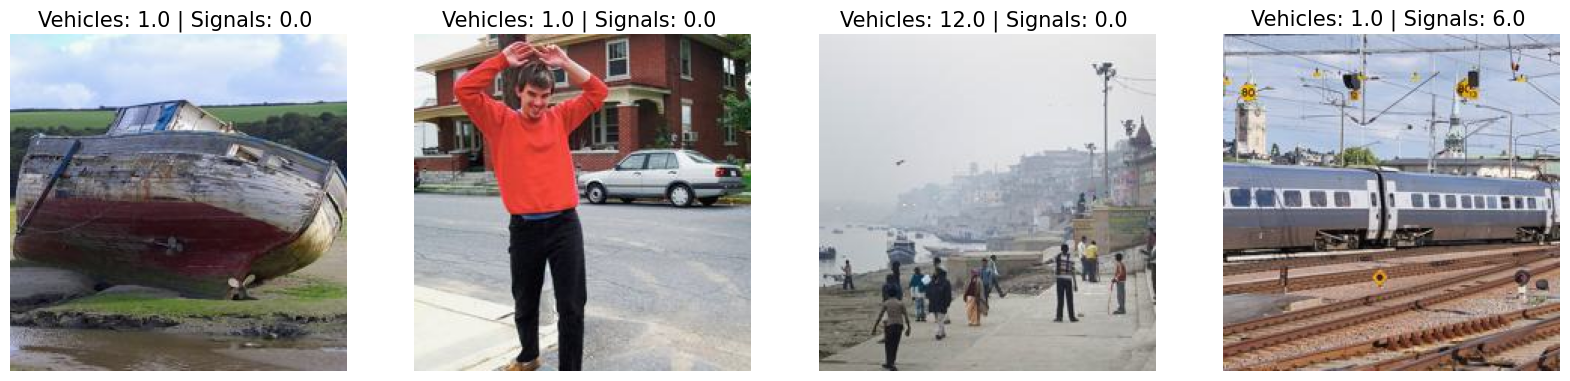

In [8]:
# Check out images 

# Set random seed 
random.seed(43)

# Plot images 
plt.figure(figsize=(20, 5))

for j in range(4): 
    
    i = random.randint(0, train_metadata.shape[0])
    
    file_name = train_metadata['file_name'].iloc[i]
    vehicle_num = train_metadata['vehicle'].iloc[i]
    signal_num = train_metadata['signal'].iloc[i]
    
    # plot figure 
    plt.subplot(1, 4, j+1) 
    plt.imshow(Image.open(f'carnet_dataset/train/images/{file_name}'))
    plt.axis('off')
    plt.title(f"Vehicles: {vehicle_num} | Signals: {signal_num} ", fontsize = 15)

In [9]:
# Score metadata defines the expected order of the photos in the submitted predictions file.
score_metadata = pd.read_csv('carnet_dataset/score/metadata.csv')
score_metadata.head()

,file_name
0,000000000071.jpg
1,000000000149.jpg
2,000000000260.jpg
3,000000000307.jpg
4,000000000690.jpg


### Part 3B. Prepare Data

In [10]:
train_metadata.head()

,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal,file_name
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,000000000064.jpg
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000000073.jpg
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000074.jpg
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,000000000081.jpg
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000086.jpg


In [11]:
# Get labels 
labels = train_metadata.iloc[ : , :-1 ].values

In [12]:
# Get images / inputs 
image_filenames = train_metadata['file_name'].values

In [14]:
# preprocess data 
images_inputs = load_and_preprocess_images(image_filenames)
images_inputs[0].shape

(224, 224, 3)

In [230]:
# Split the data 
# We will be using an ensemble model, hence the various datasets 

# Split into two sets -- one for training the original models, one for training the ensemble model 
X_first, X_second, y_first, y_second = train_test_split(images_inputs, labels, test_size=0.2, random_state=42)

# Split the first set into train, val 
X_train, X_val, y_train, y_val = train_test_split(X_first, y_first, test_size=0.1, random_state=42)

# Split the second set into blender & test 
X_blend, X_test, y_blend, y_test = train_test_split(X_second, y_second, test_size=0.4, random_state=42)

In [231]:
# We are training different models on differet y_outputs

# Create individual labels 
y_train_individual_labels = y_train[:, :10]
y_val_individual_labels = y_val[:, :10]
y_blend_individual_labels = y_blend[:, :10]
y_test_individual_labels = y_test[:, :10]

# Create category labels 
y_train_category_labels = y_train[:, 10:]
y_val_category_labels = y_val[:, 10:]
y_blend_category_labels = y_blend[:, 10:]
y_test_category_labels = y_test[:, 10:]

In [232]:
# We want to delete data we're no longer using 
# This will help with GPU / space issues 

del X_first, y_first, X_second, y_second
del y_train, y_val, y_blend, y_test

In [233]:
# This following section will help with managing computational resources 

with tf.device('/CPU:0'):
    X_train = tf.constant(X_train)
    X_val = tf.constant(X_val)
    X_blend = tf.constant(X_blend)
    X_test = tf.constant(X_test)
    
    y_train_individual_labels = tf.constant(y_train_individual_labels)
    y_val_individual_labels = tf.constant(y_val_individual_labels)
    y_blend_individual_labels = tf.constant(y_blend_individual_labels)
    y_test_individual_labels = tf.constant(y_test_individual_labels)
    
    y_train_category_labels = tf.constant(y_train_category_labels)
    y_val_category_labels = tf.constant(y_val_category_labels)
    y_blend_category_labels = tf.constant(y_blend_category_labels)
    y_test_category_labels = tf.constant(y_test_category_labels)

In [234]:
# Look at shapes 
print("Training dataset  :", X_train.shape, y_train_individual_labels.shape, y_train_category_labels.shape) 
print("Validation dataset:", X_val.shape, y_val_individual_labels.shape, y_val_category_labels.shape) 
print("Blend dataset     :", X_blend.shape, y_blend_individual_labels.shape, y_blend_category_labels.shape) 
print("Test dataset      :", X_test.shape, y_test_individual_labels.shape, y_test_category_labels.shape) 

Training dataset  : (16723, 224, 224, 3) (16723, 10) (16723, 2)
Validation dataset: (1859, 224, 224, 3) (1859, 10) (1859, 2)
Blend dataset     : (2787, 224, 224, 3) (2787, 10) (2787, 2)
Test dataset      : (1859, 224, 224, 3) (1859, 10) (1859, 2)


In [235]:
# For evaluation purposes (later) 
y_test_vehicles = np.array(y_test_category_labels[ : , 0 ])
y_test_signals = np.array(y_test_category_labels[ : , 1 ])

<br/>

## Part 4. Modelling 

### Part 4A. CNN

In [293]:
epoch_choice = 10
batch_size_choice = 32

In [295]:
# Define model 
model_a = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(), # new 
    #Conv2D(128, (3, 3), activation='relu'),
    #MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y_train_individual_labels.shape[1], activation='linear')
])

# Compile model 
#model_a.compile(optimizer='adam', loss='mean_squared_error')
model_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0075), loss='mean_squared_error') 

model_a.fit(X_train, y_train_individual_labels, epochs=epoch_choice, batch_size=batch_size_choice, verbose = 1, validation_data=(X_val, y_val_individual_labels)) 

Epoch 1/10
523/523 [==============================] - 21s 40ms/step - loss: 277.6944 - val_loss: 1.7755
Epoch 2/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7713 - val_loss: 1.7675
Epoch 3/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7165 - val_loss: 1.7418
Epoch 4/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7104 - val_loss: 1.7374
Epoch 5/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7103 - val_loss: 1.7336
Epoch 6/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7129 - val_loss: 1.7568
Epoch 7/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7103 - val_loss: 1.7610
Epoch 8/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7109 - val_loss: 1.7347
Epoch 9/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7106 - val_loss: 1.7516
Epoch 10/10
523/523 [==============================] - 21s 40ms/step - loss: 1.7

In [296]:
# For evaluation purposes, let's check how it would perform for test set 

# Get predictions 
model_a_pred = model_a.predict(X_test)

# Round predictions 
model_a_pred_rounded = np.rint(model_a_pred)

# Create df 
model_a_pred_df = pd.DataFrame(model_a_pred_rounded)


# Create arrays 
model_a_pred_vehicles = np.array(model_a_pred_df.loc[:, 0:7].sum(axis=1))
model_a_pred_signals = np.array(model_a_pred_df.loc[:, 8:9].sum(axis=1))


In [297]:
# Check out MSE 
model_a_test_vehicles_mse = mean_squared_error(y_test_vehicles, model_a_pred_vehicles)
model_a_test_signals_mse = mean_squared_error(y_test_signals, model_a_pred_signals)
model_a_test_mse = 0.5 * ( model_a_test_vehicles_mse + model_a_test_signals_mse ) 

print(model_a_test_vehicles_mse)
print(model_a_test_signals_mse)
print(model_a_test_mse)

17.344271113501883
2.235610543302851
9.789940828402367


### Part 4B. MobileNet

In [298]:
# Load MobileNet
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
mobile_net.trainable = False

In [368]:
# Define model
model_b = tf.keras.models.Sequential([
    mobile_net,
    GlobalAveragePooling2D(),
    #Dense(1024, activation='relu'), 
    Dense(y_train_individual_labels.shape[1], activation='linear')
])

# Compile model
model_b.compile(optimizer='adam', loss='mean_squared_error') 

# Train model 
model_b.fit(X_train, y_train_individual_labels, epochs=epoch_choice, batch_size=batch_size_choice, verbose = 1, validation_data=(X_val, y_val_individual_labels)) 

# model_b.fit(X_train, y_train_individual_labels, epochs=epoch_choice, batch_size=batch_size_choice, verbose = 1, validation_data=(X_val, y_val_individual_labels), 
# callbacks=[ ReduceLROnPlateau(monitor='val_loss', min_delta=0.2,patience=5,factor=0.1,cooldown=10),EarlyStopping(monitor='val_loss',min_delta=0.2,patience=10,mode='min')]) 

Epoch 1/10
523/523 [==============================] - 22s 39ms/step - loss: 1.4508 - val_loss: 1.2541
Epoch 2/10
523/523 [==============================] - 20s 38ms/step - loss: 1.2358 - val_loss: 1.1961
Epoch 3/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1843 - val_loss: 1.1865
Epoch 4/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1563 - val_loss: 1.1843
Epoch 5/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1428 - val_loss: 1.1761
Epoch 6/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1307 - val_loss: 1.1788
Epoch 7/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1262 - val_loss: 1.1578
Epoch 8/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1215 - val_loss: 1.1677
Epoch 9/10
523/523 [==============================] - 20s 38ms/step - loss: 1.1170 - val_loss: 1.1624
Epoch 10/10
523/523 [==============================] - 20s 38ms/step - loss: 1.114

In [369]:
# For evaluation purposes, let's check how it would perform for test set 

# Get predictions 
model_b_pred = model_b.predict(X_test)

# Round predictions 
model_b_pred_rounded = np.rint(model_b_pred)

# Create df 
model_b_pred_df = pd.DataFrame(model_b_pred_rounded)


# Create arrays 
model_b_pred_vehicles = np.array(model_b_pred_df.loc[:, 0:7].sum(axis=1))
model_b_pred_signals = np.array(model_b_pred_df.loc[:, 8:9].sum(axis=1))

#np.array(train_pred_df.loc[:, 0:7].sum(axis=1))

In [370]:
# Check out MSE 
model_b_test_vehicles_mse = mean_squared_error(y_test_vehicles, model_b_pred_vehicles)
model_b_test_signals_mse = mean_squared_error(y_test_signals, model_b_pred_signals)
model_b_test_mse = 0.5 * ( model_b_test_vehicles_mse + model_b_test_signals_mse ) 

print(model_b_test_vehicles_mse)
print(model_b_test_signals_mse)
print(model_b_test_mse)

8.974717590102205
1.593329747175901
5.284023668639053


In [ ]:
#9.26, 1.54, 5.4 

### Part 4C. ResNet

In [419]:
# Load resnet model 
res_net = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet", 
    pooling='avg'
)
res_net.trainable = False

In [ ]:
# Define model
model_c = tf.keras.models.Sequential([
    res_net,
    Flatten(), 
    Dense(y_train_individual_labels.shape[1], activation='linear')
    # Dense(128, activation='relu'), 
    # Flatten(), 
    # Dense(64, activation='relu'), 
    # Flatten(), 
    # #Dense(1024, activation='relu'), 
    # Dense(y_train_individual_labels.shape[1], activation='linear')
])

# Compile model
# model_c.compile(optimizer='adam', loss='mean_squared_error')
model_c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0075), loss='mean_squared_error') 

# Train model 
model_c.fit(X_train, y_train_individual_labels, epochs=5, batch_size=batch_size_choice, verbose = 1, validation_data=(X_val, y_val_individual_labels)) 

Epoch 1/5
523/523 [==============================] - 50s 92ms/step - loss: 1.7515 - val_loss: 1.6543
Epoch 2/5
523/523 [==============================] - 47s 91ms/step - loss: 1.6941 - val_loss: 1.6586
Epoch 3/5
523/523 [==============================] - 47s 91ms/step - loss: 1.6792 - val_loss: 1.6557
Epoch 4/5
523/523 [==============================] - 47s 90ms/step - loss: 1.6556 - val_loss: 1.6597
Epoch 5/5
523/523 [==============================] - 47s 90ms/step - loss: 1.6556 - val_loss: 1.6325


In [ ]:
# For evaluation purposes, let's check how it would perform for test set 

# Get predictions 
model_c_pred = model_c.predict(X_test)

# Round predictions 
model_c_pred_rounded = np.rint(model_c_pred)

# Create df 
model_c_pred_df = pd.DataFrame(model_c_pred_rounded)


# Create arrays 
model_c_pred_vehicles = np.array(model_c_pred_df.loc[:, 0:7].sum(axis=1))
model_c_pred_signals = np.array(model_c_pred_df.loc[:, 8:9].sum(axis=1))

In [ ]:
# Check out MSE 
model_c_test_vehicles_mse = mean_squared_error(y_test_vehicles, model_c_pred_vehicles)
model_c_test_signals_mse = mean_squared_error(y_test_signals, model_c_pred_signals)
model_c_test_mse = 0.5 * ( model_c_test_vehicles_mse + model_c_test_signals_mse ) 

print(model_c_test_vehicles_mse)
print(model_c_test_signals_mse)
print(model_c_test_mse)

12.592791823561054
2.0215169445938677
7.307154384077461


In [ ]:
# 11.77, 2.95, 6.91 

<br/>

## Part 5. Ensemble Model

In [ ]:
# Create blended meta X

# Generate meta-features for the blending set
meta_features_a_pre = model_a.predict(X_blend)
meta_features_b_pre = model_b.predict(X_blend)
meta_features_c_pre = model_c.predict(X_blend)

# created rounded 
meta_features_a_rounded = np.rint(meta_features_a_pre)
meta_features_b_rounded = np.rint(meta_features_b_pre)
meta_features_c_rounded = np.rint(meta_features_c_pre)

# create df 
meta_features = np.column_stack( (meta_features_a_rounded, meta_features_b_rounded, meta_features_c_rounded) ) 

In [ ]:
# Do the same for X test 

# Generate meta-features for the testing set
meta_features_a_test = model_a.predict(X_test)
meta_features_b_test = model_b.predict(X_test)
meta_features_c_test = model_c.predict(X_test)

# created rounded 
meta_features_a_test = np.rint(meta_features_a_test)
meta_features_b_test = np.rint(meta_features_b_test)
meta_features_c_test = np.rint(meta_features_c_test)

# create df 
meta_features_test = np.column_stack( (meta_features_a_test, meta_features_b_test, meta_features_c_test) ) 

In [426]:
# define ensemble model 
blender_model = Sequential([
    Dense(64, activation='relu', input_shape=(meta_features.shape[1],)),
    Flatten(), 
    Dense(10, activation='linear')  
])

# compile 
blender_model.compile(optimizer='adam', loss='mean_squared_error')

# train 
blender_model.fit(meta_features, y_blend_individual_labels, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
79/79 [==============================] - 0s 2ms/step - loss: 1.9838 - val_loss: 1.6933
Epoch 2/50
79/79 [==============================] - 0s 2ms/step - loss: 1.4008 - val_loss: 1.5310
Epoch 3/50
79/79 [==============================] - 0s 2ms/step - loss: 1.2890 - val_loss: 1.4718
Epoch 4/50
79/79 [==============================] - 0s 2ms/step - loss: 1.2421 - val_loss: 1.4510
Epoch 5/50
79/79 [==============================] - 0s 2ms/step - loss: 1.2148 - val_loss: 1.4451
Epoch 6/50
79/79 [==============================] - 0s 2ms/step - loss: 1.1977 - val_loss: 1.4387
Epoch 7/50
79/79 [==============================] - 0s 2ms/step - loss: 1.1858 - val_loss: 1.4379
Epoch 8/50
79/79 [==============================] - 0s 2ms/step - loss: 1.1766 - val_loss: 1.4337
Epoch 9/50
79/79 [==============================] - 0s 2ms/step - loss: 1.1644 - val_loss: 1.4269
Epoch 10/50
79/79 [==============================] - 0s 2ms/step - loss: 1.1560 - val_loss: 1.4232
Epoch 11/50
79/79 [

In [427]:
# Test Set predictions 

# Get predictions 
blender_pred = blender_model.predict(meta_features_test)

# Round predictions 
blender_pred_rounded = np.rint(blender_pred)

# Create df 
blender_pred_df = pd.DataFrame(blender_pred_rounded)

# Create arrays 
blend_pred_vehicles = np.array(blender_pred_df.loc[:, 0:7].sum(axis=1))
blend_pred_signals = np.array(blender_pred_df.loc[:, 8:9].sum(axis=1))

In [428]:
# Check out MSE 
blend_test_vehicles_mse = mean_squared_error(y_test_vehicles, blend_pred_vehicles)
blend_test_signals_mse = mean_squared_error(y_test_signals, blend_pred_signals)
blend_test_mse = 0.5 * ( blend_test_vehicles_mse + blend_test_signals_mse ) 

print(blend_test_vehicles_mse)
print(blend_test_signals_mse)
print(blend_test_mse)

8.496503496503497
1.5346960731576116
5.015599784830554


## Part 6. Create Scoring Data Predictions

In [431]:
# Prepare scoring data 
scoring_images = score_metadata['file_name'].values
scoring_inputs = score_load_and_preprocess_images(scoring_images)

In [436]:
scoring_inputs[0].shape

(224, 224, 3)

In [437]:
with tf.device('/CPU:0'):
    scoring_inputs = tf.constant(scoring_inputs)

In [441]:
# Generate score data meta_features 
score_meta_features_a_pre = model_a.predict(scoring_inputs)
score_meta_features_b_pre = model_b.predict(scoring_inputs)
score_meta_features_c_pre = model_c.predict(scoring_inputs)

# created rounded 
score_meta_features_a_rounded = np.rint(score_meta_features_a_pre)
score_meta_features_b_rounded = np.rint(score_meta_features_b_pre)
score_meta_features_c_rounded = np.rint(score_meta_features_c_pre)

# create df 
score_meta_features = np.column_stack( (score_meta_features_a_rounded, score_meta_features_b_rounded, score_meta_features_c_rounded) ) 

In [464]:
# Get predictions 
score_predictions = blender_model.predict(score_meta_features)

# Round predictions 
score_predictions_rounded = np.rint(score_predictions)

# Create df 
score_predictions_df = pd.DataFrame(score_predictions_rounded)

# Create arrays 
score_vehicles = np.array(score_predictions_df.loc[:, 0:7].sum(axis=1))
score_signals = np.array(score_predictions_df.loc[:, 8:9].sum(axis=1))

# Create df 
score_df = pd.DataFrame(np.column_stack((score_signals, score_vehicles)))
score_df.columns = ['signal', 'vehicle']

In [465]:
score_df

,signal,vehicle
0,1.0,3.0
1,1.0,3.0
2,0.0,3.0
3,0.0,1.0
4,0.0,2.0
...,...,...
5761,0.0,4.0
5762,0.0,5.0
5763,0.0,5.0
5764,0.0,2.0


## Part 6. Saving the Model and Predictions

In [468]:
# Save your predictions on the Score segment as a Pandas data frame into a variable named `score_y_hat`.
# The data frame should contain 2 columns: signal and vehicle.
# The following is an EXAMPLE of what this data frame could be.
score_y_hat = score_df.copy()

# Use the following asserts to check the type and shape of the final predictions.
assert type(score_y_hat) == pd.DataFrame
assert score_y_hat.shape == (score_metadata.shape[0], 2)
assert (score_y_hat.columns == ['signal', 'vehicle']).all()

# Use the following code to save the final predictions.

model_dir = 'carnet_model'
os.makedirs(model_dir, exist_ok=True)
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

In [469]:
# Next, save each model's defition (JSON file) and parameters (H5 file).

model_dir = 'carnet_model'
os.makedirs(model_dir, exist_ok=True)

# Save model definition:

# Model A: 
# Model definition
with open(f'{model_dir}/model_a.json', 'w') as f:
    model_json = json.dumps(json.loads(model_a.to_json()), indent=True)
    f.write(model_json)
# Save the learned parameters.
model_a.save_weights(f"{model_dir}/model_a_parameters.h5")

# Model B: 
# Model definition
with open(f'{model_dir}/model_b.json', 'w') as f:
    model_json = json.dumps(json.loads(model_b.to_json()), indent=True)
    f.write(model_json)
# Save the learned parameters.
model_b.save_weights(f"{model_dir}/model_b_parameters.h5")

# Model C: 
# Model definition
with open(f'{model_dir}/model_c.json', 'w') as f:
    model_json = json.dumps(json.loads(model_c.to_json()), indent=True)
    f.write(model_json)
# Save the learned parameters.
model_c.save_weights(f"{model_dir}/model_c_parameters.h5")

# Ensemble Model: 
# Model definition
with open(f'{model_dir}/blender_model.json', 'w') as f:
    model_json = json.dumps(json.loads(blender_model.to_json()), indent=True)
    f.write(model_json)
# Save the learned parameters.
blender_model.save_weights(f"{model_dir}/blender_model_parameters.h5")

In [470]:
# You now have the following files to be submit:
# 1. This notebook and any other Python code you used to train the final model.
# 2. definitions of all trained models
# 3. parameters of all trained models
# 4. score_y_hat.parquet - the model's output on the score segment